In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError

### Data preparation

In [4]:
dataset = (tfds.load('smallnorb', as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train']))

In [5]:
ds = tfds.load('smallnorb', split="test")
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(tfds.as_numpy(ds)):
        images.append(image['image'])
        labels.append(label)

    return images

np_img = dataset_to_numpy(dataset)
np.save('dataset.npy', np_img)

2023-12-17 01:09:15.138561: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: too many values to unpack (expected 2)

In [36]:
a = np.load("dataset.npy")
train_dataset = tf.data.Dataset.load('dataset.npy')
train_dataset

FailedPreconditionError: dataset.npy/dataset_spec.pb; Not a directory

In [16]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [17]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
list(train_dataset.take(1).as_numpy_iterator())

2023-12-16 23:52:17.648221: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[(array([[[132],
          [132],
          [132],
          ...,
          [130],
          [131],
          [131]],
  
         [[131],
          [131],
          [131],
          ...,
          [130],
          [130],
          [130]],
  
         [[131],
          [131],
          [131],
          ...,
          [130],
          [130],
          [130]],
  
         ...,
  
         [[132],
          [132],
          [132],
          ...,
          [130],
          [130],
          [130]],
  
         [[132],
          [132],
          [132],
          ...,
          [131],
          [130],
          [130]],
  
         [[132],
          [132],
          [132],
          ...,
          [131],
          [131],
          [131]]], dtype=uint8),
  4)]

In [18]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(96, 96, 1), dtype=uint8, numpy=
array([[[132],
        [132],
        [132],
        ...,
        [130],
        [131],
        [131]],

       [[131],
        [131],
        [131],
        ...,
        [130],
        [130],
        [130]],

       [[131],
        [131],
        [131],
        ...,
        [130],
        [130],
        [130]],

       ...,

       [[132],
        [132],
        [132],
        ...,
        [130],
        [130],
        [130]],

       [[132],
        [132],
        [132],
        ...,
        [131],
        [130],
        [130]],

       [[132],
        [132],
        [132],
        ...,
        [131],
        [131],
        [131]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(96, 96, 1), dtype=uint8, numpy=
array([[[223],
        [223],
        [223],
        ...,
        [223],
        [223],
        [223]],

       [[223],
        [223],
        [223],
        ...,
        [223],
        [223],


2023-12-16 23:52:20.052486: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-17 00:26:43.922218: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 4) + inhomogeneous part.

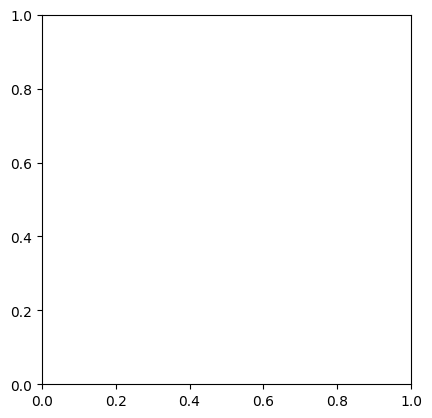

In [32]:
for i, image in enumerate(train_dataset.take(1)):
    ax = plt.subplot(1, 1, 1)
    plt.imshow(image)
    # plt.title(dataset_info.features['label_category'].int2str(label))
    plt.axis('off')

In [23]:
IM_SIZE = 96
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [24]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [63]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.50980395]
  [0.5137255 ]
  [0.5137255 ]]

 [[0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 [[0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 ...

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.5137255 ]
  [0.50980395]
  [0.50980395]]

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]]], shape=(96, 96, 1), dtype=float32)


In [29]:
BATCH_SIZE = 4
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [65]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Flatten(),
                             Dense(100, activation='relu'),
                             BatchNormalization(),
                             Dense(10, activation='relu'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid'),
])
lenet_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 92, 92, 6)         456       
                                                                 
 batch_normalization_36 (Ba  (None, 92, 92, 6)         24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 46, 46, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 42, 42, 16)        2416      
                                                                 
 batch_normalization_37 (Ba  (None, 42, 42, 16)        64        
 tchNormalization)                                               
                                                      

In [66]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 1)),
                            Conv2D(16, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Conv2D(32, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Conv2D(64, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Flatten(), 
                            Dense(128, activation='relu'), 
                            BatchNormalization(),
                            Dense(30, activation='relu'),
                            BatchNormalization(),
                            Dense(5, activation='sigmoid'),
])
lenet_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 batch_normalization_40 (Ba  (None, 96, 96, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_41 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                      

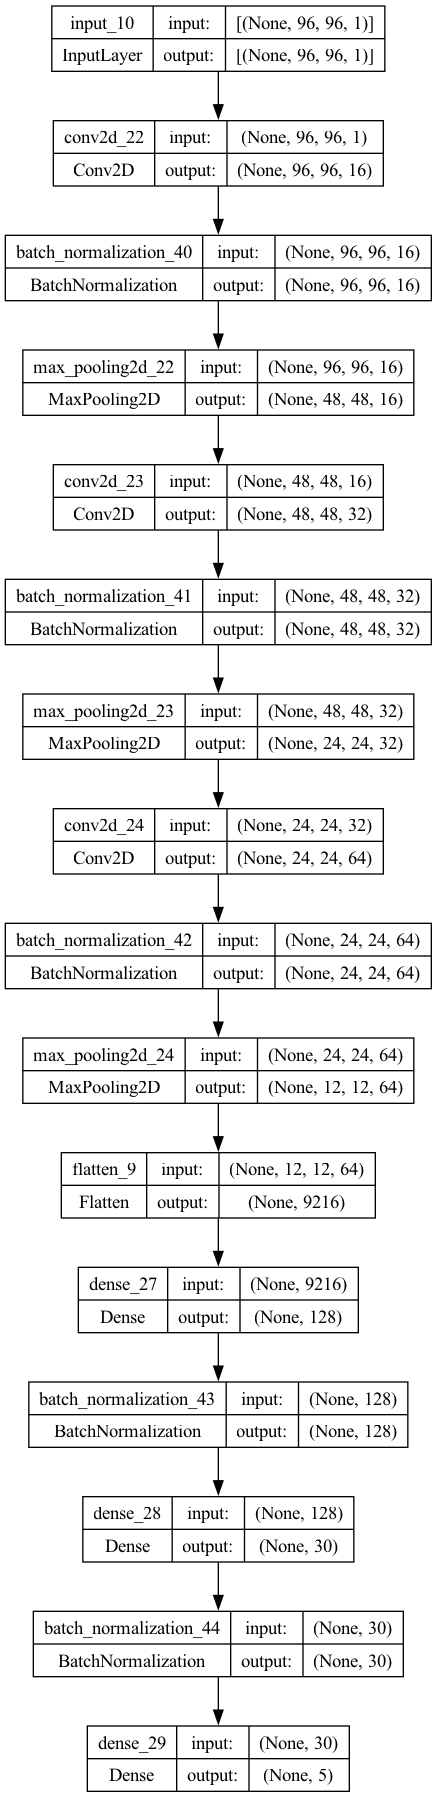

In [67]:
tf.keras.utils.plot_model(model=lenet_model, to_file="model.png", show_shapes=True)

In [68]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy( 
                  from_logits=True),
              metrics='accuracy')
tf.keras.models.load_model()

In [69]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=15, verbose=1)

Epoch 1/15


4860/4860 [==============================] - 79s 16ms/step - loss: 1.1733 - accuracy: 0.5177 - val_loss: 2.8702 - val_accuracy: 0.3798
Epoch 2/15
 891/4860 [====>.........................] - ETA: 1:04 - loss: 0.8990 - accuracy: 0.6571

KeyboardInterrupt: 

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: name 'history' is not defined

In [270]:
lenet_model.evaluate(test_dataset)

608/608 [==============================] - 3s 4ms/step - loss: 53.7960 - accuracy: 0.9901


[53.79604721069336, 0.990123450756073]

In [271]:
test_dataset = test_dataset.shuffle(buffer_size=8)

In [26]:
def decide_type(l: list):
    if (l[0] == l[1] or l[0] == l[2] or l[0] == l[3] or l[0] == l[4]
        or l[1] == l[2] or l[1] == l[3] or l[1] == l[4] or l[2] == l[3]
        or l[2] == l[4] or l[3] == l[4]):
        return "underfined"
    if np.argmax(l) == 0:
        return "animal"
    if np.argmax(l) == 1:
        return "human"
    if np.argmax(l) == 2:
        return "plane"
    if np.argmax(l) == 3:
        return "truck"
    if np.argmax(l) == 4:
        return "car"

In [25]:
lenet_model = tf.keras.models.load_model('model.h5')

1/1 [==============================] - 0s 15ms/step
[0.07634783 0.06788605 0.22314668 0.27895224 0.99479616]
1/1 [==============================] - 0s 14ms/step
[0.09722849 0.01339383 0.09494115 0.9995436  0.32812923]
1/1 [==============================] - 0s 20ms/step
[0.10881666 0.03258181 0.00173987 0.13852006 0.9999734 ]
1/1 [==============================] - 0s 15ms/step
[0.02325243 0.01127166 0.19189048 0.89285403 0.9951464 ]
1/1 [==============================] - 0s 15ms/step
[0.03028137 0.25541574 0.02195409 0.09781884 0.99981046]
1/1 [==============================] - 0s 15ms/step
[0.7817542  0.05983277 0.99989307 0.29289848 0.01559284]
1/1 [==============================] - 0s 14ms/step
[9.9983156e-01 2.5354758e-01 2.1177850e-04 1.4003889e-01 9.2098135e-01]
1/1 [==============================] - 0s 14ms/step
[0.04062659 0.99999213 0.02183992 0.00558528 0.31099778]
1/1 [==============================] - 0s 15ms/step
[0.99815077 0.9940557  0.01299047 0.11358619 0.02020958]


2023-12-17 00:27:26.844929: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


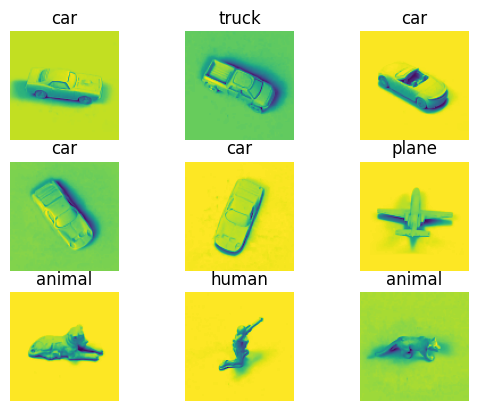

In [34]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(str(decide_type(lenet_model.predict(image)[0])))
    print(lenet_model.predict(image)[0])
    plt.axis('off')

In [11]:
ds = tfds.load('smallnorb', split="test")
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i, image in enumerate(tfds.as_numpy(ds)):
        images.append(image['image'])
        # labels.append(label)
        np.save(f'test_case_{i}.npy', image['image'])
        if (i > 99): break

    return images

np_img = dataset_to_numpy(ds)
np.save('dataset.npy', np_img)

2023-12-17 01:43:21.133546: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [41]:
dataset = tf.data.Dataset.from_tensor_slices((np.load("test_case_0.npy")))
dataset = dataset.shuffle(4).batch(4)


In [39]:
lenet_model = tf.keras.models.load_model('model.h5')

TypeError: Image data of dtype object cannot be converted to float

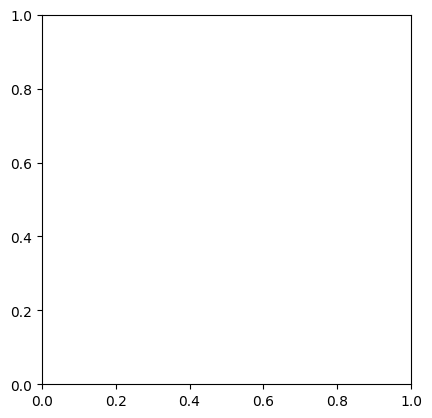

In [43]:

ax = plt.subplot(1, 1, 1)
plt.imshow(dataset.take(1))
    # plt.title(str(decide_type(lenet_model.predict(image)[0])))
print(lenet_model.predict(dataset.take(1))[0])
plt.axis('off')

1/1 [==============================] - 0s 156ms/step
plane
Spent: 0:00:00.399172
1/1 [==============================] - 0s 16ms/step
[0.96970916 0.00601914 0.00229781 0.9999959  0.02081916]


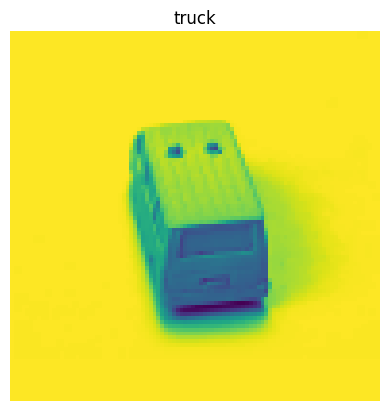

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()

IM_SIZE = 96
BATCH_SIZE = 4

def resize_rescale(image):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

def decide_type(l: list):
    if (l[0] == l[1] or l[0] == l[2] or l[0] == l[3] or l[0] == l[4]
        or l[1] == l[2] or l[1] == l[3] or l[1] == l[4] or l[2] == l[3]
        or l[2] == l[4] or l[3] == l[4]):
        return "underfined"
    if np.argmax(l) == 0:
        return "animal"
    if np.argmax(l) == 1:
        return "human"
    if np.argmax(l) == 2:
        return "plane"
    if np.argmax(l) == 3:
        return "truck"
    if np.argmax(l) == 4:
        return "car"

dataset = tf.data.Dataset.from_tensor_slices((np.load("dataset.npy")))
dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE)

lenet_model = tf.keras.models.load_model('model.h5')

for i, (image) in enumerate(dataset.take(1)):
    np.save('result.npy', image[0])

dataset = dataset.map(resize_rescale)

print(str(decide_type(lenet_model.predict(dataset.take(1))[0])) + "\nSpent: " + str(datetime.now() - start))

for i, (image) in enumerate(dataset.take(1)):
    ax = plt.subplot(1, 1, i + 1)
    plt.imshow(image[0])
    plt.title(str(decide_type(lenet_model.predict(image)[0])))
    print(lenet_model.predict(image)[0])
    plt.axis('off')